# ***CBOW (continuos bag of words)***

In [2]:
import gensim.downloader as api
import numpy as np

In [3]:
dataset = api.load('text8')

[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
k = 0
for i in dataset:
  k += 1
  print(i)

  if k == 10:
    break

In [5]:
doc_length = []

for x in dataset:
  x = len(x)
  doc_length.append(x)

In [6]:
np.mean(doc_length)

# 10000 words per document

9997.182245737802

In [7]:
len(doc_length)

# 1701 documents

1701

*creating sequence of numbers for this text data*

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
vocab_size = 20000

tokenize = Tokenizer(num_words=vocab_size)

In [10]:
tokenize.fit_on_texts(dataset)

In [11]:
seq = tokenize.texts_to_sequences(dataset)

In [12]:
len(seq[1])

9497

In [ ]:
tokenize.word_index

In [ ]:
tokenize.index_word

*creating neural network*

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Embedding,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [19]:
context_size = 10
dimensions = 50

In [20]:
i = Input(shape=(context_size,))
p = Embedding(vocab_size,dimensions)(i)
p = Lambda(lambda x:tf.reduce_mean(x,axis=1))(p)
p = Dense(vocab_size,use_bias=False)(p)

In [21]:
model = Model(i,p)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 10, 50)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20000)          │     1,000,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import math
import random

def generate_data(sequences,batch_size=128):
  half_context = context_size//2
  n_batches = int(math.ceil(len(sequences)/batch_size))
  X_batch = np.zeros((batch_size,context_size))
  Y_batch = np.zeros(batch_size)

  while True:
    random.shuffle(sequences)

    for i in range(n_batches):
      batch_seq = sequences[i*batch_size:(i+1)*batch_size]

      for k in range(len(batch_seq)):
        seq = batch_seq[k]

        j = np.random.randint(0, max(0, len(seq)-context_size-1))
        x1 = seq[j:j+half_context]                        # left to the target word
        x2 = seq[j+half_context+1:j+context_size+1]           # right to the target word

        X_batch[k,:half_context] = x1
        X_batch[k,half_context:context_size] = x2
        x = seq[j+half_context]
        Y_batch[k] = x

      yield X_batch[:len(batch_seq)],Y_batch[:len(batch_seq)]

In [24]:
model.compile(optimizer='adam',loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
fitted_mod = model.fit(generate_data(seq,128),epochs=10000,steps_per_epoch=int(math.ceil(len(seq)/128)))

# since 1 epoch will consider only one context window which does not cover all the 10000 words in our document.

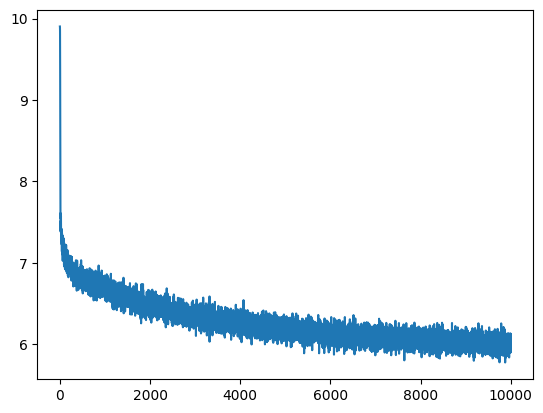

In [26]:
import matplotlib.pyplot as plt

plt.plot(fitted_mod.history['loss'])

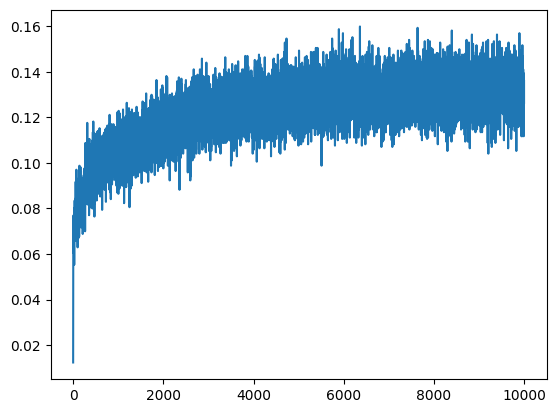

In [27]:
plt.plot(fitted_mod.history['accuracy'])

***Generating Five similar word to our given word***

In [ ]:
word_embeddings = model.layers[1].get_weights()[0]

In [ ]:
word_embeddings

In [32]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
help(NearestNeighbors)

In [64]:
neighbor = NearestNeighbors(n_neighbors=5,algorithm='ball_tree',radius=0.1)

In [65]:
neighbor.fit(word_embeddings)

NearestNeighbors(algorithm='ball_tree', radius=0.1)

In [66]:
def similar_words(word):
    idx = tokenize.word_index[word]
    word = word_embeddings[idx:idx+1]
    distance,indices = neighbor.kneighbors(word)

    for i in indices[0]:
        word_ = tokenize.index_word[i]
        print(word_)

In [71]:
similar_words('heat')

heat
heating
thermal
radiation
vapor


In [74]:
import pickle

with open('tokenizer.pickle','wb') as handle:
    pickle.dump(tokenize,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
model.save('similar_words.keras')